## Overview
This is the Jupyter Notebook for the Georgia Tech ESRI Albany Hub Analytics and Visualization Project.  This version of the notebook incorporates a program analysis to quantify changes in energy use in Albany, GA among participants of HUD-funded programs. The first part implements matching algorithms that reduce observable bias in order to compare participants and non-participants.  The second part includes ArcGIS interactive visuals supplementing the analysis.  The visuals are intended to be used by cities to interpret results with spatial information.  


The code here takes performance data from HUD-funded properties and compares them to properties that do not receive HUD funding but have been matched on similar attributes.  The matching attributes include variables such as baseline energy consumption prior to receiving HUD funding, property size in square feet, number of bedrooms, number of batherooms, year built, market value, and assessment value.  To validate the effectiveness of the matching procedures, the code also calculates the reductions in standardize bias for each of the matching variables with results shown before and after matching.  After a suitable matching model is selected, the code then estimates the energy savings by a difference-in-differences regression and also includes time dummies to control for seasonal trends in annual energy use.  
 

### Files Needed
Two files are needed to utilize this code. The first file contains information about the properties before the treatment period used for matching. The second file needed is a panel dataset that contains the time-varying variables such as energy use during the pre- and post-treatment period. The records linkage between files is done with the AddressID field which indicates the unit of analysis is at the property level.

### User Authentication
In order to engage with the full interactive visuals generated by the code, an active ArcGIS account is necessary to establish a connection to the server.  You will be prompted to enter your password when creating the ArcGIS items from your data files.


### Data Dictionary
These attributes are the variables we identified as indicitive of whether or not a house would receive HUD funding. Outlined below are the units and format we had our data in to begin with to ensure correct execution of the code. 

 - "Baseline" - Average household baseline energy consumption (kWh/square foot)
 - "Size" - Area of the property (sqaure foot)
 - "Beds" - Number of bedrooms in the house (integer)
 - "Baths" - Number of bathrooms in the house (integer)
 - "YearBuilt" - Year the house was built (date)
 - "Market" - Market value of the home (dollars)
 - "Assessment" - Assessed value of the property (dollars)
 - "Group" - Binary treatment indicator that takes a value of 1 if receiving HUD funding and 0 otherwise
 - "Project" - Categorical variable indicating what type of project the funding was used on (string)
 - "Program" - Categorical variable indicating what funding source the project utilized (string)
 - "AddressID" - Numeric indicator for a given address (integer)
 - "Address" - Address for a given property (string)
 - "Premise" - Numeric indicator used by the utility company for a given property (integer)
 - "Index" - Numeric index for all treated and untreated properties (integer)
 - "NormConsumption" - Average household energy consumption (kWh/sqaure foot) per unit measurement
 - "Post" - Binary indicator that takes a value of 1 if a given datapoint occurs after treatment and 0 otherwise
 - "Post_Group" - Binary interaction variable that takes a value of 1 if a given datapoint is both after treatment is given and a member of the funded group and 0 otherwise
 - "Year_XXXX" - A set of binary indicator variables that take a value of 1 if a datapoint occurs in a given year and 0 otherwise
 - "TimePeriod" - Numeric indicator representing the month and year that a given datapoint takes place in. 1 represents January 2004, 2 represecents February 2004, etc. (integer)

# Variable Definitions

### Path Assignments (A)
1.  Assign the "matchPath" variable the file location for property data before the treatment period.

2.  Assign the "panelPath" variable the file location for the data containing time-varying variables later used to estimate treatment effects.

3. Assign the "treatPath" variable the file location for the data containing data about the group receiving treatment.

### Field Assignments (B)
1. In the "matchFields" list, insert column headers from the "matchDF" indicating the factors that are likely to influence the probablity a unit is receiving HUD funding.
2. In the "extraFields" list, insert column headers from the "matchDF" for non-matching fields to integrate into the analysis other than those influencing the probability of receiving funding.
3. In the "dependent" list, insert a column header from the "panelDF" identifying the dependent variable you want to measure the effects of.
4. In the "independent" list,  insert column headers from the "panelDF" identifying the time and treatment group dummy variables.

### Preparing Test and Control Data (C)
1. Assign "mergeIndex" the column header of the "matchDF" index for easy merging later.
2. Assign "timeIndex" the column header denoting time from the panel dataset.
3. Assign "yvar" the column header indicating whether an entity belongs to the treatment group or not.
4. Specify a random seed value for repeatable results.
5. Set "nmodels" to the amount of models desired to fit propensity scores.
6. Define 'nmatches' to # of untreated entities to be matched to the treated entities.
7. Define 'threshold' to be absolute value of the max difference in propensity scores.

### Creating New Data Sets (F)
1. Specify a path to save your new dataframe as a csv file on your machine.
2. Identify the unique identifier shared between panel data and the new match table to merge on.

### Uploading Items to ArcGIS Online (G)
1. Enter ArcGIS account credentials to establish a connection to ArcGIS Online.
2. Assign the 'name_list' list the names of files to check to see if they already exist.
3. Create variables representing all items you'd like to publish in order
4. Separate the variables by type in lists in order
5. Assign the 'csv_file_list' list the paths of the files to add to the ArcGIS Online platform.
6. Set titles and tags for the CSV files to be published.
7. Assign 'properties_list' the properties created in order.

### ArcGIS Interactive Visuals (H)
1. Assign a list of layer names to search for on ArcGIS Online.
2. Create a list of layers found to later add to the map.
3. Assign the location of the center of the map.
4. Set the basemap.
5. Assign the field to account for the appearance of the layer to create.
6. Create a renderer for the layer you aim to create.
7. Add information to the renderer such as color, symbol type, label values, etc.

### Fixed Effect Panel Regression (I)
1. Set the index of 'mergeDF' to a variable unique to each entity and a time variable.
2. Assign a new column in 'mergeDF' the product of the treatment time period and the treatment group columns.
3. Build a PanelOLS model to estimate the changes observed with the dependent variable.
4. Fit the model to estimate the model parameters.

### Energy Savings Analysis (J)
1. Assign FIPS codes for the state and county the data is from in string format.
2. Assign the column names of important information like tract, house size, baseline, etc.
3. Assign the column name to merge the treatMerge dataframe on with the matched data.
4. Assign the file path where the treatMerge dataframe will be saved.

In [16]:
# PATH ASSIGNMENTS (A) 

# (A1, A2, A3) Data locations
matchPath = "/Users/Kira/Documents/ESRI_Research_Project/OverallStats.csv"
panelPath = "/Users/Kira/Dropbox/ResidentialElectricPanelData2.csv"
treatPath = '/Users/Kira/Documents/ESRI_Research_Project/Treatment1.csv'

# FIELD ASSIGNMENTS (B)

# (B1) List of matching attributes 
matchFields = \
[
    "Baseline",
    "Size",
    "Beds",
    "Baths",
    "YearBuilt",
    "Market",
    "Assessment",
    "Group"
 ]

# (B2) List of additional non-matching fields to be integrated into the analysis 
extraFields = \
[
    "Project",
    "Program",
    "AddressID",
    "Index",
    "Premise",
    "Address"
]

# (B3) Dependent variable 
dependent = \
[
    "NormConsumption"
]

# (B4) List of dummy variables
independent = \
[
    "Post",
    "Post_Group",
    "Year_2005",
    "Year_2006",
    "Year_2007",
    "Year_2008",
    "Year_2009",
    "Year_2010",
    "Year_2011",
    "Year_2012",
    "Year_2013",
    "Year_2014",
    "Year_2015",
    "Year_2016",
    "Year_2017",
    "Year_2018",
    "Year_2019"
]


# PREPARING TEST AND CONTROL DATA (C)

# (C1) Identify index to merge datasets on
mergeIndex = 'Index'

# (C2) Identify time index from panel data
timeIndex = 'TimePeriod'

# (C3) Treatment identifyer definition
yvar = 'Group'

# (C4) Choose random seed for replication
randSeed = 20170925

# (C5) Specify # of models to fit propensity scores to
nmodels = 100

# (C6 & C7) Specify parameters for matching
nmatches = 2
threshold = 0.0001

# CREATING NEW DATASETS (F)

# (F1) Specifiy a path to save the new dataframe to
savePath = "/Users/Kira/Documents/ESRI_Research_Project/New_Table.csv"

# (F2) Specify what column you will merge the panel data to the new match data on
panelMergeCol = 'Premise'


# UPLOADING ITEMS TO ARCGIS ONLINE (G)

# (G1) Assign your ArcGIS username
username = "kohare6_albgis"

# (G2) Specify names of items to check for existence
name_list = ["Treated Houses","Baseline Consumption"]

# (G3) Create variables for items to publish
treatment_csv = None
treatment_lyr = None
baseline_csv = None
baseline_lyr = None

# (G4) Separate the items for publish by item type
publish_csv_list = [treatment_csv, baseline_csv]
publish_lyr_list = [treatment_lyr, baseline_lyr]

# (G5) CSV files to add to ArcGIS Online platform
csv_file_list = \
[
    "/Users/Kira/Documents/ESRI_Research_Project/Treatment1.csv",
    "/Users/Kira/Documents/ESRI_Research_Project/OverallStats1.csv",
]

# (G6) Setting titles and tags for the CSV file detailing treated houses
treatment_properties = \
{
    'title': 'Treated Houses',
    'tags': 'albany, hud participants'
}

# (G6) Repeat step 6 to set titles and tags for the CSV file detailing baseline energy consumption of Albany houses
baseline_properties = \
{
    'title': 'Baseline Consumption',
    'tags': 'energy usage, albany, housing'
}

# (G7) Create a list of desired properties in order
properties_list = [treatment_properties, baseline_properties]

# ARCGIS INTERACTIVE VISUALS (H)

# (H1) Assign a list of layers you'd like to search
searchLayer = ["City Ward"]

# (H2) Create a list of layers searched to add to the map
wards_lyr = None 
layer_list = [wards_lyr]

# (H3) Set the map location
mapLoc = 'Albany, GA'

# (H4) Set the basemap to use
basemap = 'gray-vector'

# (H5) Specify the field to illustrate with the layer addition
field_name = 'Program' 

# (H6) Define a renderer for a new layer
treatment_renderer = {'renderer':'autocast',
                      'type':'uniqueValue',
                      'field1':'Program'}

# (H7) Add information to the renderer
treatment_renderer['uniqueValueInfos'] = [{"value":"HOME",
                                          "symbol": {
                                              "color": [0,0,0,255],
                                              "size": 6,
                                              "angle":0,
                                              "xoffset":0,
                                              "yoffset":0,
                                              "type":"esriSMS",
                                              "style":"esriSMSCircle",
                                              "outline": {
                                                  "color":[255,255,255,255],
                                                  "width":0.75,
                                                  "type":"esriSLS",
                                                  "style":"esriSolid"
                                              }
                                          },
                                          "label": "HOME"
                                         },
                                         {"value": "CDBG",
                                          "symbol": {
                                              "color": [255,255,255,255],
                                              "size": 6,
                                              "angle":0,
                                              "xoffset":0,
                                              "yoffset":0,
                                              "type":"esriSMS",
                                              "style":"esriSMSCircle",
                                              "outline": {
                                                  "color":[0,0,0,255],
                                                  "width":0.75,
                                                  "type":"esriSLS",
                                                  "style":"esriSolid"
                                              }
                                          },
                                          "label":"CDBG"
                                          }]

itemid = '5a8ca7fec77d496fb91de38e8bf382cc'

# ENERGY SAVINGS ANALYSIS (J)

# (J1) Assign FIPS codes for state and county data is from
fips_state = '13'
fips_county = '095'

# (J2) Assign the column names of important information like tract, house size, baseline, etc.
tractCol = 'Tract'
bgCol = 'BlockGroup'
sizeCol = 'Size'
baselineCol = 'Baseline'

# (J3) Assign the column name you would like to merge the treatMerge dataframe on with the matched data
treatMergeCol = 'AddressID'

# (J4) Assign the file path where the treatMerge dataframe will be saved
treatMergeCSV = 'treatMerge.csv'

## Package Installation and Import

In [17]:
!pip -q install pymatch
!pip -q install linearmodels

import warnings
warnings.filterwarnings('ignore')
from pymatch.Matcher import Matcher
import pandas as pd
import numpy as np
import statistics as stat
import math
import pymatch.functions as uf
from linearmodels import PanelOLS

%matplotlib inline
import matplotlib.pyplot as plt

## Dataframe Creation

In [18]:
# Reads in data from CSV files to create respective data frames
matchDF = pd.read_csv(matchPath)
panelDF = pd.read_csv(panelPath)

## Matching

### Preparing Test and Control Data (C)
1. Separate "covData" into test and control groups based on the value of your yvar.
2. Create a Matcher object to assign propensity scores to units indicating the likelihood of belonging to the treatment group.
3. Fit propensity scores.
4. Match the data and define method of matching.

In [19]:
covData = matchDF[matchFields]
mergeData = matchDF[extraFields]

# Aligning indices between data frames for easy merging
mergeData.set_index(mergeIndex,inplace=True)

# (C1) Separates data into treated and non-treated groups
test = covData[covData[yvar] == 1]
control = covData[covData[yvar] == 0]

# Identifies the column indicating whether a property receives funding
test[yvar] = 1
control[yvar] = 0

# (C2) Assigns propensity scores to units and returns a matching formula
m = Matcher(test, control, yvar = yvar, exclude=[]) 

# Random number generator for easy replication
np.random.seed(randSeed)

# (C3) Fits propensity scores to specified number of models
m.fit_scores(balance=True, nmodels = nmodels) 

# Returns score that indicates how accurately observed outcomes are replicated by model
m.predict_scores()

# (C4) Matches data with replacement and places the matches into a data frame
m.match(method="min", nmatches=nmatches, threshold=threshold) 
m.assign_weight_vector()

Formula:
Group ~ Baseline+Size+Beds+Baths+YearBuilt+Market+Assessment
n majority: 19815
n minority: 307
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 69.19%


## Preparing the Plots
### Calculating Standardized Percent Bias (D)
1. Assign "trb" and "cob" to the respective test and control columns of the m data frame before matching. 
2. Assign "tra" and "coa" to the respective test and control columns of the m.matched_data data frame after matching.
3. Calculate the standardized percent bias both before and after matching.
4. Append these calculations to the "test_results" and "test_results_after lists".

### Creating the Bias Reduction Graph (E)
1. Adjust the parameters to the graph if desired.  For example, change figsize to create a larger or smaller graph, change the color and width of the lines, and modify the names of the labels as needed.


Text(0.5, 1.0, 'PSM Bias Reduction')

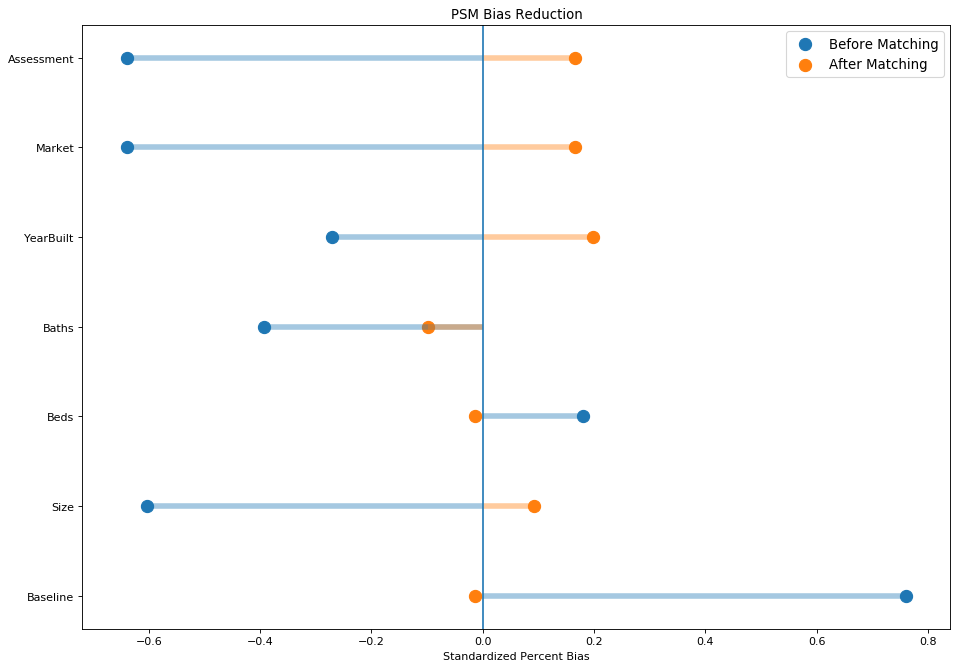

In [20]:
# Preparing data for plotting a bias graph
test_results = []
test_results_after = []
y = []

# Iterates through every matching attribute
for col in m.matched_data.columns:
    if uf.is_continuous(col,m.X) and col not in m.exclude:
        # (D1) Assign the values for the test and control group before matching
        trb, cob = m.test[col], m.control[col]
        # (D2) Assign the values for the test and control group after matching
        tra = m.matched_data[m.matched_data[m.yvar]==True][col]
        coa = m.matched_data[m.matched_data[m.yvar]==False][col]
        # (D3) Calculate the standardized percent bias before and after matching
        std_diff_mean_before = (stat.mean(trb) - stat.mean(cob))/((math.sqrt(stat.variance(trb)+stat.variance(cob)))/2)
        std_diff_mean_after = (stat.mean(tra) - stat.mean(coa))/((math.sqrt(stat.variance(tra)+stat.variance(coa)))/2)
        # (D4) Append the calculations to the lists used to plot the results 
        test_results.append(std_diff_mean_before)
        test_results_after.append(std_diff_mean_after)
        y.append(col)
    

# (E1) Plotting the bias reduction graph
plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y=y, xmin=0, xmax=[test_results], color=[m.control_color], alpha=0.4,linewidth=5)
plt.hlines(y=y, xmin=0, xmax=[test_results_after], color=[m.test_color],alpha=0.4,linewidth=5)
plt.scatter(test_results, y, s=120, color = m.control_color, label='Before Matching')
plt.scatter(test_results_after, y, s=120, color = m.test_color, label='After Matching')
plt.legend(prop={'size': 12})
plt.xlabel('Standardized Percent Bias')
plt.axvline(x=0)
plt.title('PSM Bias Reduction')

## Creating New Data Sets (F)
1. Change the 'record_id' column of 'matches_table' to add 1 to every value because record_id automatically assigns indices to houses beginning with 0.
2. Change the name to match the index column in the 'matchDF'.
3. Merge the data and on the specified index that uniquely identifies each house.
4. Create a CSV file for personal reference if desired.
5. Merge 'panelDF' with 'new_table' on a unique identifier shared between data frames.

In [21]:
matches_table = (m.matched_data.sort_values('match_id'))

# Assigns a unique value to every property matched
matches_table['ID'] = list(range(1,matches_table.shape[0]+1))

# (F1) If your 'matchDF' starts at a different value than 0, adjust record_id to reflect the same value
matches_table.record_id = matches_table.record_id + 1

# (F2) Rename the 'record_id' column to reflect the 'matchDF' index
matches_table.rename({'record_id': mergeIndex},axis=1,inplace=True)

# (F3) Merge the data on the specified index 
new_table = pd.merge(mergeData,matches_table,on=mergeIndex,how='right')
new_table.drop(new_table.columns[new_table.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

# (F4) Creates a csv file for desired data
new_table.to_csv(savePath,header=True,index=False)

# (F5) Merge matched data with panel data
mergeDF = pd.merge(panelDF,new_table,on=panelMergeCol,how='right')
mergeDF.drop(mergeDF.columns[mergeDF.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
mergeDF = mergeDF.drop_duplicates(subset=['ID', timeIndex])


fipsDF = pd.read_csv("/Users/Kira/Documents/ESRI_Research_Project/OverallStats1.csv")
fipsDF['State'] = fips_state
fipsDF['County'] = fips_county

# Make the 'Tract' column type string of length 6
fipsDF[tractCol] = fipsDF[tractCol].astype(int)
fipsDF[tractCol] = fipsDF[tractCol].astype(str)
fipsDF[bgCol] = fipsDF[bgCol].astype(int)
fipsDF[bgCol] = fipsDF[bgCol].astype(str)
  
for index, row in fipsDF.iterrows():
    if len(row[tractCol]) != 6:
        tract_value = row[tractCol].zfill(6)
    fipsDF.at[index,tractCol] = tract_value
    
fipsDF['FIPS_Code'] = fipsDF['State']+fipsDF['County']+fipsDF[tractCol]+fipsDF[bgCol]

## Uploading Items to ArcGIS Online (G)
1. Enter ArcGIS account credentials to establish a connection to ArcGIS Online.
2. Add the first CSV file as a CSV item on ArcGIS Online.
3. Use the first CSV item to publish a Feature Layer mapping data points using coordinates on ArcGIS online.

In [22]:
# Import the GIS class to create a connection to ArcGIS Online.
from arcgis.gis import GIS
from IPython.display import display
from arcgis.mapping import WebMap
from IPython.display import IFrame
import getpass
import os

# (G1) Enter ArcGIS Online credentials
password = getpass.getpass("Enter password: ")
gis = GIS("https://www.arcgis.com", username, password)

# Method that checks if files exist for smooth creation of new files
def check_existing_items(item_type, file_name): 
    search_result = gis.content.search(query=file_name, item_type=item_type)
    if len(search_result) > 0:
        return True
        print(file_name + " exists")
    else:
        return False
        print("The file " + file_name + " does not exist")

for x in range(0,len(publish_csv_list)):
    if check_existing_items('CSV',name_list[x]) == False:
        # (G2) Add CSV file for treated houses to ArcGIS account
        publish_csv_list[x] = gis.content.add(item_properties = properties_list[x],  data = csv_file_list[x])
        display(publish_csv_list[x])    
    else:
        publish_csv_list[x] = gis.content.search(query=name_list[x], item_type='CSV')[0]
        display(publish_csv_list[x])
    
for x in range(0,len(publish_lyr_list)):
    if check_existing_items('Feature Layer',name_list[x]) == False:    
        # (G3) Add a Feature Layer mapping the houses with coordinates to ArcGIS account
        publish_lyr_list[x] = treatment_csv.publish()
        display(publish_lyr_list[x])
    else:
        publish_lyr_list[x] = gis.content.search(query=name_list[x], item_type='Feature Layer')[0]
        display(publish_lyr_list[x])

Enter password: ········


<Item title:"Treated Houses" type:CSV owner:kohare6_albgis>

<Item title:"Baseline Consumption" type:CSV owner:kohare6_albgis>

<Item title:"Treated Houses" type:Feature Layer Collection owner:kohare6_albgis>

<Item title:"Baseline Consumption" type:Feature Layer Collection owner:kohare6_albgis>

## ArcGIS Interactive Visuals (H)
1. Search for and define existing layers on ArcGIS Online to add to the map.
2. Set the location to center the map with.
3. Set the basemap.
4. Add the searched layers to the map.
5. Add a layer created from scratch and define characteristics such as 'renderer', 'field_name', 'opacity', etc.

In [23]:
# (H1) Search existing layers to add to a map
for layer in range(0,len(searchLayer)):
    layer_list[layer] = gis.content.search(searchLayer[layer])[0]

# (H2) Set map location
map1 = gis.map(mapLoc,zoomlevel=11)

# (H3) Set the basemap
map1.basemap = basemap

# (H4) Add searched layers to the map
for layer in range(0, len(layer_list)):
    map1.add_layer(layer_list[layer],{'opacity':0.4})

# (H5) Add a layer to the map created from scratch

map1.add_layer(publish_lyr_list[1], {'type':'FeatureLayer',
                               'renderer':treatment_renderer,
                               'field_name': field_name,
                                'opacity':1})

display(map1)

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

In [24]:
from arcgis.features.analysis import aggregate_points
from arcgis.mapping.renderer import generate_renderer

webmap_item = gis.content.get(itemid)
webmap = WebMap(webmap_item)
display(webmap)

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

## Fixed Effect Panel Regression (I)
1. Set the index of 'mergeDF' to a variable unique to each entity and a time variable.
2. Assign a new column in 'mergeDF' the product of the treatment time period and the treatment group columns.
3. Build a PanelOLS model to estimate the changes observed with the dependent variable.
4. Fit the model to estimate the model parameters.
5. Assign 'savings_coef' the expected change in energy consumption.

In [25]:
# (I1) Indexes by individual entity and time variables
mergeDF.set_index(['ID',timeIndex],inplace=True)

# (I2) Creates a new column to reflect energy useage for houses receiving HUD funding after the treatment period
mergeDF['Post_Group'] = mergeDF['Post'] * mergeDF[yvar]

# (I3) PanelOLS model to estimate the change in energy consumption
model = PanelOLS(mergeDF[dependent],mergeDF[independent],entity_effects=True,time_effects=False)

# (I4) Fit the model to estimate the model parameters
fit = model.fit(cov_type = 'clustered', cluster_entity=True,cluster_time=True)

# (I5) Assign the projected energy change coefficient from the regression
savings_coef = fit.params['Post_Group']

print(fit)


                          PanelOLS Estimation Summary                           
Dep. Variable:        NormConsumption   R-squared:                        0.0206
Estimator:                   PanelOLS   R-squared (Between):             -0.0780
No. Observations:              163488   R-squared (Within):               0.0206
Date:                Thu, May 28 2020   R-squared (Overall):             -0.0578
Time:                        08:23:08   Log-likelihood                -1.253e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      200.77
Entities:                         921   P-value                           0.0000
Avg Obs:                       177.51   Distribution:               F(17,162550)
Min Obs:                       53.000                                           
Max Obs:                       186.00   F-statistic (robust):             2.8942
                            

## Energy Savings Analysis (J)
1. Read in the housing data specific to treated entities.
2. Create an energy savings dataframe by census tract to get geospatial savings.
3. Assign tract labels for a barchart.
4. Spatially orient the labels on the chart and set width.
5. Plot the bars of energy consumption (kWh) before and after treatment.
6. Add labels for the title, axes, etc.
7. Create labels for monthly energy savings (kWh).
8. Add the labels to the tops of the bars to better visualize savings.
9. Merge energy savings dataframe with matching dataframe save as a CSV for reference.

,FIPS_Code,Initial_Norm_Baseline,After_Norm_Baseline,Avg_Size,Initial_Avg_Baseline,After_Avg_Baseline,Avg_Monthly_Energy_Savings,Yearly_Monetary_Savings,Monetary_Before,Monetary_After,Monthly_Monetary_Savings
0,130950001001,1.244952,1.198635,1034.500000,1287.902663,1239.988049,47.914614,68.134581,129.508966,123.831084,5.677882
1,130950001002,0.542364,0.522186,1260.000000,683.378378,657.954243,25.424135,36.153120,57.872838,54.860078,3.012760
2,130950001003,0.900085,0.866598,1047.142857,942.517272,907.452237,35.065035,49.862479,88.580797,84.425590,4.155207
3,130950001004,0.795834,0.766226,1466.000000,1166.692265,1123.287114,43.405151,61.722125,115.145533,110.002023,5.143510
4,130950001005,1.839660,1.771218,1216.000000,2237.027027,2153.801570,83.225457,118.346599,241.980203,232.117986,9.862217
5,130950002001,0.872143,0.839697,1241.666667,1082.911497,1042.623292,40.288205,57.289828,105.217512,100.443360,4.774152
6,130950002002,1.202441,1.157706,1125.285714,1353.089966,1302.750150,50.339817,71.583219,137.233661,131.268393,5.965268
7,130950002003,1.073274,1.033345,1237.571429,1328.253793,1278.837972,49.415822,70.269298,134.290575,128.434800,5.855775
8,130950002004,0.887553,0.854533,1043.888889,926.506406,892.037034,34.469373,49.015448,86.683509,82.598888,4.084621
9,130950004002,1.475434,1.420543,1389.000000,2049.378379,1973.134127,76.244251,108.419326,219.743838,210.708894,9.034944


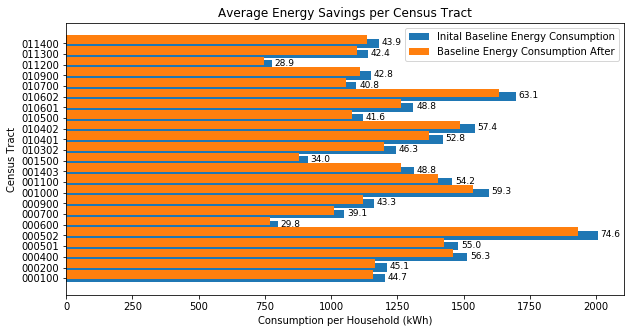

In [28]:
!pip install plotly-geo
import plotly.figure_factory as ff
import pandas as pd
import plotly.graph_objects as go
import geopandas as gpd
import plotly.express as px
import json
from urllib.request import urlopen

# (J1) Read in housing data
treatDF = pd.read_csv(treatPath)
treatDF['State'] = fips_state
treatDF['County'] = fips_county

# Make the 'Tract' column type string of length 6
treatDF[tractCol] = treatDF[tractCol].astype(int)
treatDF[tractCol] = treatDF[tractCol].astype(str)
treatDF[bgCol] = treatDF[bgCol].astype(int)
treatDF[bgCol] = treatDF[bgCol].astype(str)
  
for index, row in treatDF.iterrows():
    if len(row[tractCol]) != 6:
        tract_value = row[tractCol].zfill(6)
    treatDF.at[index,tractCol] = tract_value

treatDF.insert(0, 'FIPS_Code', treatDF['State']+treatDF['County']+treatDF[tractCol]+treatDF[bgCol])

# Calculating basic energy savings information from treated houses data
avg_size = treatDF[sizeCol].mean()
avg_baseline = treatDF[baselineCol].mean()
con_bef = avg_size*avg_baseline
con_af = con_bef - abs(avg_size*avg_baseline*savings_coef)
con_sav = abs(avg_size*avg_baseline*savings_coef)

# (J2) Create a tractSavingsDF that includes a FIPS Code for geocoding and the respective average Baseline Consumption    
tractSavingsDF = treatDF.groupby(tractCol, as_index = False)[baselineCol].mean()
tractSavingsDF.rename(columns={baselineCol:'Initial_Norm_Baseline'},inplace=True)
tractSavingsDF['After_Norm_Baseline'] = tractSavingsDF['Initial_Norm_Baseline'] - abs(savings_coef*tractSavingsDF['Initial_Norm_Baseline'])
tractSavingsDF['Avg_Size'] = treatDF.groupby(tractCol,as_index=False)[sizeCol].mean()[sizeCol]
tractSavingsDF.insert(0, 'FIPS_Code', '13'+'095'+tractSavingsDF[tractCol])
tractSavingsDF['Initial_Avg_Baseline'] = tractSavingsDF['Initial_Norm_Baseline']*tractSavingsDF['Avg_Size']
tractSavingsDF['After_Avg_Baseline'] = tractSavingsDF['Initial_Avg_Baseline'] -abs(tractSavingsDF['Initial_Norm_Baseline']*tractSavingsDF['Avg_Size']*savings_coef)
tractSavingsDF['Avg_Monthly_Energy_Savings'] = abs(tractSavingsDF['Initial_Norm_Baseline']*tractSavingsDF['Avg_Size']*savings_coef)

tractSavingsDF['Monetary_Before'] = 0
tractSavingsDF['Monetary_After'] = 0
high_indexes = tractSavingsDF[tractSavingsDF['Initial_Avg_Baseline'] > 650].index
tractSavingsDF.loc[high_indexes,'Monetary_Before'] = 650*0.082950 + (tractSavingsDF['Initial_Avg_Baseline'] - 650) * 0.1185
low_indexes = tractSavingsDF[tractSavingsDF['Initial_Avg_Baseline'] <= 650].index
tractSavingsDF.loc[low_indexes,'Monetary_Before'] = 0.082950 * tractSavingsDF['Initial_Avg_Baseline']

high_indexes1 = tractSavingsDF[tractSavingsDF['After_Avg_Baseline'] > 650].index
tractSavingsDF.loc[high_indexes1,'Monetary_After'] = 650*0.082950 + (tractSavingsDF['After_Avg_Baseline'] - 650) * 0.1185
low_indexes1 = tractSavingsDF[tractSavingsDF['After_Avg_Baseline'] <= 650].index
tractSavingsDF.loc[low_indexes1,'Monetary_After'] = 0.082950 * tractSavingsDF['After_Avg_Baseline']
    
tractSavingsDF['Monthly_Monetary_Savings'] = tractSavingsDF['Monetary_Before'] - tractSavingsDF['Monetary_After']
tractSavingsDF['Yearly_Monetary_Savings'] = 12 * tractSavingsDF['Monthly_Monetary_Savings']


# (J3) Creat a bgSavingsDF that analyzes savings on the block group level
bgSavingsDF = treatDF.groupby('FIPS_Code', as_index = False)[baselineCol].mean()
bgSavingsDF.rename(columns={baselineCol:'Initial_Norm_Baseline'},inplace=True)
bgSavingsDF['After_Norm_Baseline'] = bgSavingsDF['Initial_Norm_Baseline'] - abs(savings_coef*bgSavingsDF['Initial_Norm_Baseline'])
bgSavingsDF['Avg_Size'] = treatDF.groupby('FIPS_Code',as_index=False)[sizeCol].mean()[sizeCol]
bgSavingsDF['Initial_Avg_Baseline'] = bgSavingsDF['Initial_Norm_Baseline']*bgSavingsDF['Avg_Size']
bgSavingsDF['After_Avg_Baseline'] = bgSavingsDF['Initial_Avg_Baseline'] -abs(bgSavingsDF['Initial_Norm_Baseline']*bgSavingsDF['Avg_Size']*savings_coef)
bgSavingsDF['Avg_Monthly_Energy_Savings'] = abs(bgSavingsDF['Initial_Norm_Baseline']*bgSavingsDF['Avg_Size']*savings_coef)
bgSavingsDF['Yearly_Monetary_Savings'] = 0.13*bgSavingsDF['Avg_Monthly_Energy_Savings']*12

bgSavingsDF['Monetary_Before'] = 0
bgSavingsDF['Monetary_After'] = 0
high_indexes = bgSavingsDF[bgSavingsDF['Initial_Avg_Baseline'] > 650].index
bgSavingsDF.loc[high_indexes,'Monetary_Before'] = 650*0.082950 + (bgSavingsDF['Initial_Avg_Baseline'] - 650) * 0.1185
low_indexes = bgSavingsDF[bgSavingsDF['Initial_Avg_Baseline'] <= 650].index
bgSavingsDF.loc[low_indexes,'Monetary_Before'] = 0.082950 * bgSavingsDF['Initial_Avg_Baseline']

high_indexes1 = bgSavingsDF[bgSavingsDF['After_Avg_Baseline'] > 650].index
bgSavingsDF.loc[high_indexes1,'Monetary_After'] = 650*0.082950 + (bgSavingsDF['After_Avg_Baseline'] - 650) * 0.1185
low_indexes1 = bgSavingsDF[bgSavingsDF['After_Avg_Baseline'] <= 650].index
bgSavingsDF.loc[low_indexes1,'Monetary_After'] = 0.082950 * bgSavingsDF['After_Avg_Baseline']
    
bgSavingsDF['Monthly_Monetary_Savings'] = bgSavingsDF['Monetary_Before'] - bgSavingsDF['Monetary_After']
bgSavingsDF['Yearly_Monetary_Savings'] = 12 * bgSavingsDF['Monthly_Monetary_Savings']

# (J3) Assigning tract labels for barchart
labels = tractSavingsDF[tractCol]
initial_baseline = tractSavingsDF['Initial_Avg_Baseline']
after_baseline = tractSavingsDF['After_Avg_Baseline']

# (J4) Set label locations and width of bars
x = np.arange(len(labels)) 
width = 0.35  
x_pos = [l+5 for l in x]

# (J5) Plot the bars for before and after energy consumption
plt.barh(x,initial_baseline,label='Inital Baseline Energy Consumption')
plt.barh(x+width,after_baseline,label='Baseline Energy Consumption After')

# (J6) Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Consumption per Household (kWh)')
plt.ylabel('Census Tract')
plt.title('Average Energy Savings per Census Tract')
plt.yticks(x,labels)
plt.legend()

# (J7) Create labels for monthly energy savings
top = tractSavingsDF['Avg_Monthly_Energy_Savings']
top = abs(top)
top = top.round(1)
 
# (J8) Text on the top of each barplot detailing kWh saved
for i in range(len(x)):
    plt.text(x = initial_baseline[i]+10 , y = x[i]-.14, s = top[i], size = 9)
    
# (J9) Create a CSV of the treatment dataframe merged with the matched data
treatMerge = pd.merge(treatDF,tractSavingsDF,on=tractCol,how='right')
treatMerge = pd.merge(matchDF,treatMerge,on=treatMergeCol,how='right')
treatMerge.to_csv(treatMergeCSV)
treatMerge1 = pd.merge(treatDF, bgSavingsDF, on='FIPS_Code',how='right')
treatMerge1 = pd.merge(matchDF, treatMerge1,on=treatMergeCol,how='right')
treatMerge1.to_csv('treatMerge1.csv')

bgSavingsDF

No handles with labels found to put in legend.


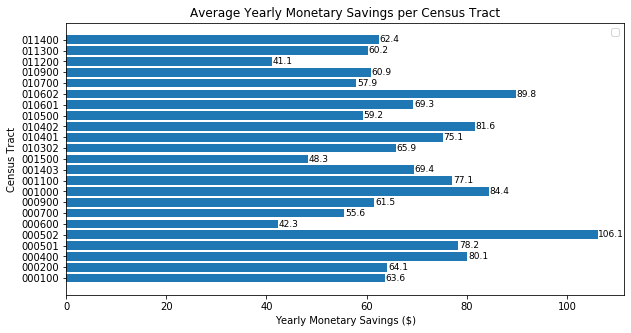

In [33]:
# (J3) Assigning tract labels for barchart
labels = tractSavingsDF[tractCol]
yearly_savings = tractSavingsDF['Yearly_Monetary_Savings']

# (J4) Set label locations and width of bars
x = np.arange(len(labels)) 
width = 0.35  
x_pos = [l+5 for l in x]

# (J5) Plot the bars for before and after energy consumption
plt.barh(x,yearly_savings)


# (J6) Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('Yearly Monetary Savings ($)')
plt.ylabel('Census Tract')
plt.title('Average Yearly Monetary Savings per Census Tract')
plt.yticks(x,labels)
plt.legend()

# (J7) Create labels for monthly energy savings
top = tractSavingsDF['Yearly_Monetary_Savings']
top = abs(top)
top = top.round(1)
 
# (J8) Text on the top of each barplot detailing kWh saved
for i in range(len(x)):
    plt.text(x = yearly_savings[i]+.14 , y = x[i]-.23, s = top[i], size = 9)